In [1]:
import sys
sys.path.append('../DreamingLearningClass/')
#sys.path.append('../Rolling_Mean/')

In [2]:
import torch
import copy
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
from random import sample
import pandas as pd

from Models import LSTM
#from DreamingLearningClass import DreamingLearningClass
#from rolling_mean import rolling_mean

In [3]:
def ma(x, wlen):
    mean = []
    std = []

    tlist = []
    len_tlist = 0
    for k, el in enumerate(x):
        if len_tlist == 0:
            tlist.append(el)
            sumt = el
            len_tlist = 1
        elif len(tlist) < wlen:
            tlist.append(el)
            sumt += el
            len_tlist += 1
        else:
            el_out = tlist.pop(0)
            tlist.append(el)
            sumt += el - el_out
        mean.append(sumt / len_tlist)

    tlist = []
    len_tlist = 0
    for k, el in enumerate(x):
        if len_tlist == 0:
            tlist.append(el)
            sumt = (el - mean[k])**2
            len_tlist = 1
        elif len(tlist) < wlen:
            tlist.append(el)
            sumt += (el - mean[k])**2
            len_tlist += 1
        else:
            el_out = tlist.pop(0)
            tlist.append(el)
            sumt += el - el_out
        std.append(np.sqrt(sumt / len_tlist))
    return mean, std

In [4]:
def entropy(distr, norm=False):
    distr = np.array(distr)
    min_bin_value = 1.e-12
    ind = np.where(distr > min_bin_value)[0]
    if norm:
        return (-distr[ind] * np.log(distr[ind])).sum() / np.log(distr.shape[0])
    else:
        return (-distr[ind] * np.log(distr[ind])).sum()

In [5]:
def KL_divergence(distr1, distr2):
    distr1 = np.array(distr1)
    distr2 = np.array(distr2)
    return (distr1 * np.log2(distr1 / distr2)).sum()

### Making Markov Chain distributions

In [6]:
n_bins = 10

In [7]:
def make_random_MC(n_bins, power=100):
    A = np.random.random(size=(n_bins, n_bins))
    for k in range(n_bins):
        A[k,:] /= A[k,:].sum()
    lim_distr = np.linalg.matrix_power(A,power)[0,:]
    return np.array(A), lim_distr

In [8]:
def make_entropy_MC(n_bins, target_entropy, norm=True, power=100, tol=0.001, factor=0.9, max_iter=1e6):
    A = np.random.random(size=(n_bins, n_bins))
    
    for k in range(n_bins):
        A[k,:] /= A[k,:].sum()
    
    it = 0
    
    while it < max_iter:
        lim_distr = np.linalg.matrix_power(A,power)[0,:]
        entr = entropy(lim_distr, norm=norm)
        
        if np.abs(entr - target_entropy) < tol:
            return A, lim_distr
        else:
            ind_node = np.random.randint(n_bins)
            ind_bin = np.random.randint(n_bins)
            A1 = A.copy()
            A1[ind_node, ind_bin] *= factor
            A1[ind_node,:] /= A1[ind_node,:].sum()
            lim_distr1 = np.linalg.matrix_power(A1,power)[0,:]
            entr1 = entropy(lim_distr1, norm=norm)
            if np.abs(entr1 - target_entropy) > np.abs(entr - target_entropy):
                A1 = A.copy()
                A1[ind_node, ind_bin] *= 2 - factor
                A1[ind_node,:] /= A1[ind_node,:].sum()
            A = A1
            it += 1
    return None, None

In [9]:
make_entropy_MC(n_bins, 0.5, norm=True, power=100, tol=0.001, factor=0.9, max_iter=1e7)

(array([[2.80038880e-01, 1.21726537e-03, 1.60236214e-03, 1.80245902e-03,
         7.41669523e-03, 5.87608746e-01, 1.15830986e-01, 2.17971908e-03,
         2.00840900e-03, 2.94478042e-04],
        [3.40246942e-01, 2.01774765e-03, 1.83526453e-04, 8.30176994e-03,
         7.21758578e-02, 2.04366739e-01, 3.63316506e-01, 2.57107450e-03,
         4.31013632e-03, 2.50969996e-03],
        [2.47760870e-01, 5.27487428e-04, 3.20263772e-03, 1.73672523e-03,
         1.12107754e-01, 3.18171456e-01, 3.11539145e-01, 2.10489342e-03,
         8.80398076e-04, 1.96863357e-03],
        [1.85338905e-01, 7.33241436e-04, 7.55225087e-04, 5.62989836e-03,
         4.38295935e-02, 2.26222122e-01, 5.29825522e-01, 2.35740999e-03,
         3.20668430e-03, 2.10139894e-03],
        [4.67290950e-01, 7.87093896e-04, 3.71484776e-04, 9.04898582e-05,
         2.83786533e-02, 1.40988568e-01, 3.59179068e-01, 1.01808586e-03,
         6.59211004e-04, 1.23639561e-03],
        [4.61580369e-01, 2.30326682e-04, 2.26246809e-03, 2.5

In [10]:
def make_perturbed_random_MC(A0, nnodes2change=-1, nbins2change=-1, maxchange=0.3, power=100):
    n_bins = A0.shape[0]
    A1 = A0.copy()
    
    if nnodes2change == -1:
        nnodes2change = np.random.randint(1, n_bins+1)
    elif nnodes2change > n_bins: nnodes2change = n_bins+1
    if nbins2change == -1:
        nbins2change = np.random.randint(1, n_bins+1)
    elif nbins2change > n_bins: nbins2change = n_bins+1
    
    ind_nodes = np.random.choice(np.arange(n_bins), size=nnodes2change, replace=False)
    ind_bins = np.random.choice(np.arange(n_bins), size=nbins2change, replace=False)
    
    for indn in ind_nodes:
        for indb in ind_bins:
            deltap = maxchange * (np.random.random() + 1) / 2.
            newval = A0[indn, indb] + deltap
            if newval > 1.:
                newval = 2 - newval
            elif newval < 0:
                newval = -newval
            A1[indn, indb] = newval
        A1[indn,:] = A1[indn,:] / A1[indn,:].sum()
    lim_distr = np.linalg.matrix_power(A1,power)[0,:]
    
    return A1, lim_distr

In [11]:
def make_seq_random_MC(A0, seq_len, nnodes2change=-1, nbins2change=-1, maxchange=0.3, power=100):
    Aseq = [A0]
    lim_distr_seq = [np.linalg.matrix_power(A0,power)[0,:]]
    A1 = A0.copy()
    for k in range(seq_len):
        A1, lim_distr1 = make_perturbed_random_MC(A1, nnodes2change=nnodes2change,
                                                  nbins2change=nbins2change, maxchange=maxchange,
                                                  power=power)
        Aseq.append(A1)
        lim_distr_seq.append(lim_distr1)
    return Aseq, lim_distr_seq

In [12]:
def sample_MC(A, n_samples, init_node=-1):
    n_bins = A.shape[0]
    if init_node == -1:
        init_node = np.random.randint(n_bins)
    samples = []
    prev_sample = init_node
    for k in range(n_samples):
        samples.append(np.random.choice(np.arange(n_bins), p=A[prev_sample,:]))
        prev_sample = samples[-1]
    return np.array(samples)

In [13]:
A, _ = make_random_MC(n_bins)
print(A.shape)
Aseq, lim_distr_seq = make_seq_random_MC(A, 5, maxchange=0.9, nnodes2change=-1, nbins2change=-1)

#for distr in lim_distr_seq:
#    plt.bar(range(n_bins), distr)
#    plt.show()
#    print(entropy(distr, norm=True))

(10, 10)


In [14]:
sample_MC(Aseq[3], 200, init_node=-1)

array([4, 7, 6, 4, 1, 6, 7, 6, 6, 9, 6, 6, 8, 9, 6, 9, 4, 9, 6, 6, 1, 6,
       9, 6, 4, 0, 6, 4, 4, 6, 7, 4, 7, 9, 9, 9, 4, 4, 6, 8, 9, 6, 6, 9,
       7, 9, 6, 9, 6, 1, 4, 1, 2, 1, 4, 9, 6, 9, 9, 9, 4, 6, 1, 6, 6, 6,
       9, 9, 9, 5, 1, 1, 9, 9, 6, 6, 9, 6, 9, 6, 6, 4, 9, 4, 4, 9, 6, 7,
       7, 9, 6, 4, 9, 9, 6, 6, 6, 9, 6, 8, 9, 9, 6, 6, 6, 9, 6, 6, 9, 9,
       9, 3, 4, 9, 6, 6, 9, 1, 9, 4, 7, 9, 6, 6, 9, 7, 6, 6, 6, 9, 6, 9,
       6, 9, 6, 7, 9, 6, 7, 7, 6, 3, 1, 6, 6, 7, 7, 6, 4, 6, 9, 6, 6, 9,
       6, 9, 6, 9, 1, 1, 4, 6, 9, 6, 5, 7, 6, 9, 1, 6, 9, 5, 1, 2, 4, 6,
       6, 4, 9, 1, 6, 9, 9, 6, 9, 7, 6, 3, 1, 9, 0, 7, 9, 6, 9, 6, 4, 9,
       6, 9])

In [15]:
A, _ = make_entropy_MC(n_bins, 0.5)
Aseq, lim_distr_seq = make_seq_random_MC(A, 8, nnodes2change=4, nbins2change=4, maxchange=0.3, power=100)

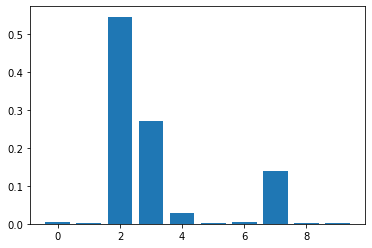

0.5009928467289178


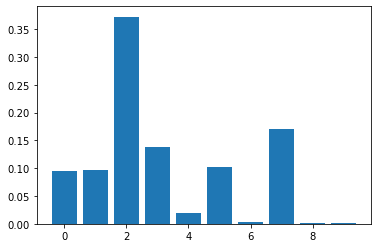

0.7537833686869406


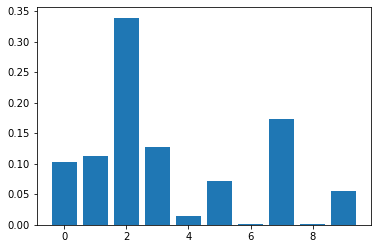

0.8001686576974714


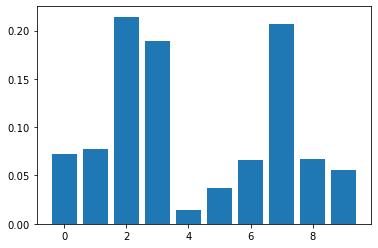

0.8960830022254552


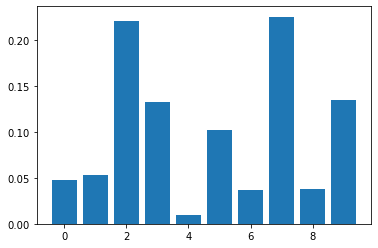

0.8822676590933757


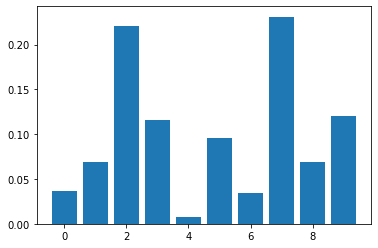

0.8872347045781157


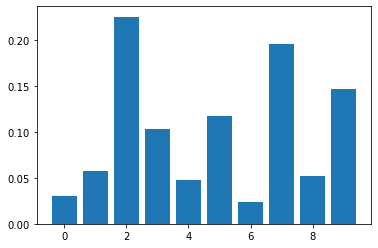

0.9045200081012587


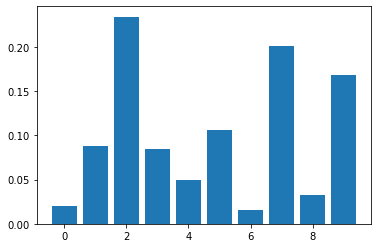

0.8807023624474714


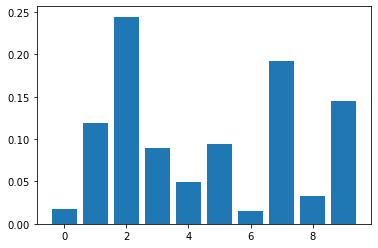

0.8807917476796022


In [16]:
for distr in lim_distr_seq:
    plt.bar(range(len(distr)), distr)
    plt.show()
    print(entropy(distr, norm=True))

#### Generating a non-stationary MC sequence

In [80]:
subseqs_len = 2000
transitions_len = 200
n_subseqs = 20

initial_entropy = 0.5

n_bins = 20

power = 100

A0, lim_distr0 = make_entropy_MC(n_bins, initial_entropy)
#print(A0.shape, lim_distr0.shape)

Aseq, lim_distr_seq = make_seq_random_MC(A0, n_subseqs, nnodes2change=4, nbins2change=4, maxchange=0.3, power=100)

samples = []
A_samples = []
lim_distr_samples = []
entropy_seq = []
init_node = -1
for k in range(n_subseqs):
    samples += list(sample_MC(Aseq[k], subseqs_len, init_node=init_node))
    for j in range(subseqs_len):
        A_samples += [Aseq[k]]
        lim_distr_samples += [lim_distr_seq[k]]
        entropy_seq += [entropy(lim_distr_samples[-1], norm=False)]
        
    # Transitions
    if k < n_subseqs - 1:
        B = np.zeros((n_bins, n_bins, transitions_len))
        B[:,:,0] = Aseq[k]
        B[:,:,-1] = Aseq[k+1]

        for i in range(n_bins):
            for j in range(n_bins):
                B[i,j,:] = np.linspace(Aseq[k][i][j], Aseq[k+1][i][j], transitions_len)
                
        for i in range(transitions_len):
            A_samples += [B[:,:,i]]
            #print(A_samples[-1].shape)
            #print(sample_MC(A_samples[-1], 1, init_node=samples[-1]))
            samples += [sample_MC(A_samples[-1], 1, init_node=samples[-1])[-1]]
            lim_distr_samples += [np.linalg.matrix_power(A_samples[-1], power)[0,:]]
            entropy_seq += [entropy(lim_distr_samples[-1], norm=False)]
            
    init_node = samples[-1]
        
samples = np.array(samples)
A_samples = np.array(A_samples)
lim_distr_samples = np.array(lim_distr_samples)


ns_seq_dict = dict()
ns_seq_dict['A'] = A_samples
ns_seq_dict['seq'] = samples
ns_seq_dict['distrs_seq'] = lim_distr_samples
ns_seq_dict['entropy_seq'] = entropy_seq

In [81]:
samples

array([1, 7, 2, ..., 1, 9, 2])

In [166]:
initial_entropy = 0.3
middle_entropy = 0.6

n_bins = 20

power = 100

Aseq = []
lim_distr_seq = []

A0, lim_distr0 = make_entropy_MC(n_bins, initial_entropy)
At = A0.copy()
lim_distrt = lim_distr0.copy()
Aseq.append(A0)
lim_distr_seq.append(lim_distr0)
A0, lim_distr0 = make_entropy_MC(n_bins, middle_entropy)
Aseq.append(A0)
lim_distr_seq.append(lim_distr0)

#A0, lim_distr0 = make_entropy_MC(n_bins, initial_entropy)
Aseq.append(At)
lim_distr_seq.append(lim_distrt)
A0, lim_distr0 = make_entropy_MC(n_bins, middle_entropy)
Aseq.append(A0)
lim_distr_seq.append(lim_distr0)

#A0, lim_distr0 = make_entropy_MC(n_bins, initial_entropy)
Aseq.append(At)
lim_distr_seq.append(lim_distrt)
A0, lim_distr0 = make_entropy_MC(n_bins, middle_entropy)
Aseq.append(A0)
lim_distr_seq.append(lim_distr0)

#A0, lim_distr0 = make_entropy_MC(n_bins, initial_entropy)
Aseq.append(At)
lim_distr_seq.append(lim_distrt)
A0, lim_distr0 = make_entropy_MC(n_bins, middle_entropy)
Aseq.append(A0)
lim_distr_seq.append(lim_distr0)

#A0, lim_distr0 = make_entropy_MC(n_bins, initial_entropy)
Aseq.append(At)
lim_distr_seq.append(lim_distrt)
A0, lim_distr0 = make_entropy_MC(n_bins, middle_entropy)
Aseq.append(A0)
lim_distr_seq.append(lim_distr0)

subseqs_len = 5000
transitions_len = 500
n_subseqs = len(Aseq)

samples = []
A_samples = []
lim_distr_samples = []
entropy_seq = []
init_node = -1
for k in range(n_subseqs):
    samples += list(sample_MC(Aseq[k], subseqs_len, init_node=init_node))
    for j in range(subseqs_len):
        A_samples += [Aseq[k]]
        lim_distr_samples += [lim_distr_seq[k]]
        entropy_seq += [entropy(lim_distr_samples[-1], norm=False)]
        
    # Transitions
    if k < n_subseqs - 1:
        B = np.zeros((n_bins, n_bins, transitions_len))
        B[:,:,0] = Aseq[k]
        B[:,:,-1] = Aseq[k+1]

        for i in range(n_bins):
            for j in range(n_bins):
                B[i,j,:] = np.linspace(Aseq[k][i][j], Aseq[k+1][i][j], transitions_len)
                
        for i in range(transitions_len):
            A_samples += [B[:,:,i]]
            #print(A_samples[-1].shape)
            #print(sample_MC(A_samples[-1], 1, init_node=samples[-1]))
            samples += [sample_MC(A_samples[-1], 1, init_node=samples[-1])[-1]]
            lim_distr_samples += [np.linalg.matrix_power(A_samples[-1], power)[0,:]]
            entropy_seq += [entropy(lim_distr_samples[-1], norm=False)]
            
    init_node = samples[-1]
        
samples = np.array(samples)
A_samples = np.array(A_samples)
lim_distr_samples = np.array(lim_distr_samples)


ns_seq_dict = dict()
ns_seq_dict['A'] = A_samples
ns_seq_dict['seq'] = samples
ns_seq_dict['distrs_seq'] = lim_distr_samples
ns_seq_dict['entropy_seq'] = entropy_seq

#### Getting eventual previous distributions

In [167]:
flag = False
if flag:
    results = torch.load('LSTM_NSdistr_Nexp_1_Temp_2.0_8.pt')
    ns_seq_dict = results[0]['ns_seq_dict']

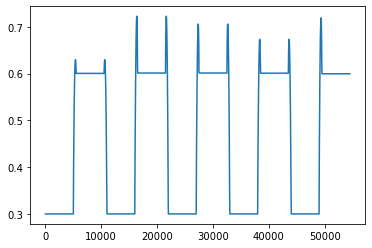

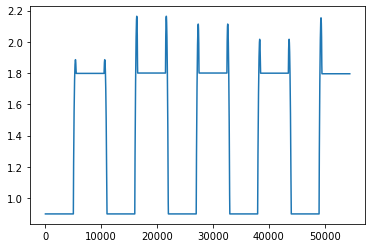

In [168]:
entropy_seq = ns_seq_dict['entropy_seq']

plt.plot(entropy_seq/np.log(n_bins))
plt.show()
plt.plot(entropy_seq)
plt.show()

In [169]:
d_KL = []
distrs_seq = ns_seq_dict['distrs_seq']
for k in range(len(distrs_seq) - 1):
    d_KL.append(KL_divergence(distrs_seq[k+1], distrs_seq[k]))
d_KL = np.array(d_KL)

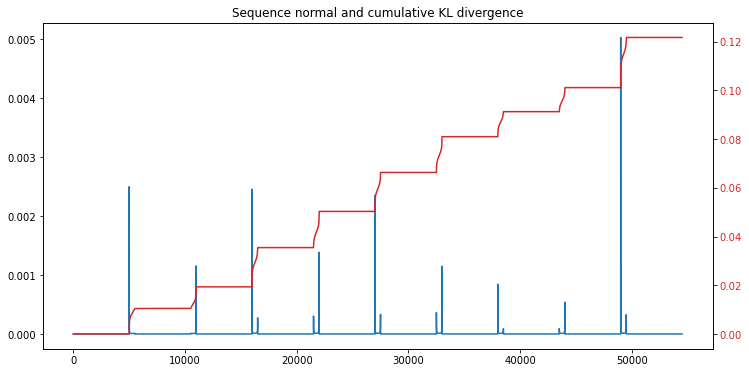

In [170]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(d_KL)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(d_KL.cumsum(), color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Sequence normal and cumulative KL divergence')
plt.show()

In [171]:
seq_length = 200
input_size = n_bins # Number of bins and input/output dimension
wlen = 10

In [172]:
config_vanilla = dict()

config_vanilla['seq_length'] = seq_length

config_vanilla['network'] = dict()
config_vanilla['network']['input_size'] = input_size
config_vanilla['network']['output_size'] = input_size
config_vanilla['network']['n_layers'] = 4
config_vanilla['network']['hidden_size'] = 100

config_vanilla['train'] = dict()
config_vanilla['train']['optimizer'] = 'Adam'
#config_vanilla['train']['optimizer'] = 'SDG'
config_vanilla['train']['criterion'] = 'CrossEntropyLoss'
config_vanilla['train']['learning_rate'] = 0.001
config_vanilla['train']['dropout'] = 0.
config_vanilla['train']['cuda'] = True
config_vanilla['train']['train_loss'] = []
config_vanilla['train']['batch_size'] = 1
config_vanilla['train']['seq_length'] = seq_length

config_vanilla['train']['learning_rate_dream'] = None
config_vanilla['train']['batch_size_dream'] = None
config_vanilla['train']['seq_length_dream'] = None # args.rnn_seq_len_dream
config_vanilla['train']['temperature_dream'] = None

In [173]:
config_dreaming = copy.deepcopy(config_vanilla)
config_dreaming['train']['learning_rate_dream'] = 0.001
config_dreaming['train']['batch_size_dream'] = 10
config_dreaming['train']['seq_length_dream'] = 100 # args.rnn_seq_len_dream
config_dreaming['train']['temperature_dream'] = 2.0

In [174]:
def train_seq(nsdict, config):
    cuda = config['train']['cuda']
    if torch.cuda.is_available() and cuda:
        device = torch.device('cuda:0')
        print('Using CUDA')
    else:
        device = torch.device('cpu')
        print('Using CPU')

    model = LSTM(config).to(device)

    hidden = model.init_hidden(1, device)
        
    lr = config['train']['learning_rate']

    if config['train']['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif config['train']['optimizer'] == 'SDG':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError('Wrong Optimizer')

    if config['train']['criterion'] == 'CrossEntropyLoss':
        criterion = torch.nn.CrossEntropyLoss()
    else:
        raise ValueError('Wrong Criterion')

    seq_length = config['seq_length']
    
    input_size = config['network']['input_size']
        
    temperature = config['train']['temperature_dream']
    
    if temperature is not None: dream = True
    else: dream = False
    
    batch_size = config['train']['batch_size']
    seq_length = config['train']['seq_length']
    
    batch_size_dream = config['train']['batch_size_dream']
    seq_length_dream = config['train']['seq_length_dream']
    lr_dream = config['train']['learning_rate_dream']
        
    train_loss = []
    distributions = []
    
    loss_past_information = []
    
    #for time_slot in range(int(np.ceil(full_period/seq_length))): # time slots with lenght=<seq_length>
    
    seq = nsdict['seq']
        
    for step in range(0, len(seq) - 1, seq_length * batch_size):
        #print('STEP', step)
        #optimizer.zero_grad()
        
        #print(len(started_countries))
        
        # Dreaming
        if dream > 0:

            optimizer.zero_grad()
            loss_d = 0.0
            
            for b in range(batch_size_dream):
                n_pre_dream_samples = np.random.randint(1, 12 + 1)
                ind0 = step - n_pre_dream_samples
                if ind0 < 0: ind0 = 0
                ind1 = step + 1
                pre_dream_samples = seq[ind0:ind1]
                with torch.no_grad():
                    model.eval()
                    hidden_d = model.init_hidden(1, device)
                    inp = torch.LongTensor([pre_dream_samples]).view(-1,1).to(device)
                    out, hidden_d, _ = model(inp, hidden_d)
                    inp = torch.LongTensor([[pre_dream_samples[-1]]]).view(-1,1)
                    sample = model.sample(inp, hidden_d, seq_length_dream, temperature, device)
                model.train()
                hidden_d = model.detach_hidden(hidden, device, clone=True)
                d = sample
                inp = sample[:-1]
                target = sample[1:]
                out, hidden_d, _ = model(inp, hidden_d)
                loss_d += criterion(out.permute(0, 2, 1), target)
            loss_d /= batch_size_dream
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_dream
            loss_d.backward()
            optimizer.step()
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                
        
        optimizer.zero_grad()
        loss = 0.0
        
        hidden = model.detach_hidden(hidden, device, clone=True)
        
        for b in range(batch_size):
            model.train()
            
            fr = step + seq_length * b
            to = fr + seq_length + 1
            ss = seq[fr:to]
            #print(fr, to, len(ss))
            inp = torch.LongTensor([ss[:-1]]).view(-1,1).to(device)
            target = torch.LongTensor([ss[1:]]).view(-1,1).to(device)
            out, hidden, distr = model(inp, hidden)
            loss += criterion(out.permute(0, 2, 1), target)
            for dd in distr:
                distributions.append(dd.detach().cpu().flatten().numpy())
            
        loss /= batch_size
        #print(loss.item())
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        # Checking the past informaion
        if step > 0:
            with torch.no_grad():
                model.eval()
                fr = 0
                to = step * seq_length + 1
                ss = seq[fr:to]
                hiddeni = model.init_hidden(1, device)
                inp = torch.LongTensor([ss[:-1]]).view(-1,1).to(device)
                target = torch.LongTensor([ss[1:]]).view(-1,1).to(device)
                out, hiddeni, distr = model(inp, hiddeni)
                lossi = criterion(out.permute(0, 2, 1), target)
                loss_past_information.append(lossi.item())
            
        clear_output(wait=True)
        print(step, train_loss[-1])
        plt.plot(train_loss)
        plt.show()
        
        temperature = -np.log(entropy(distributions[-1], norm=True))
            
    return train_loss, distributions, loss_past_information

In [175]:
ind_file = 0
forcing_train = True

54400 1.9022865295410156


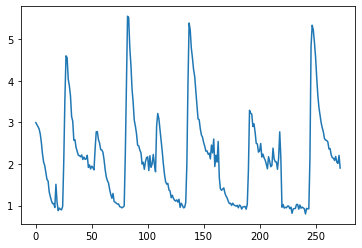

In [176]:
n_exp = 1

namefile = f"LSTM_NSdistr_Nexp_{n_exp}_Temp_{config_dreaming['train']['temperature_dream']:.1f}_{ind_file}.pt"

if os.path.isfile(namefile) is True and forcing_train is False:
    results = torch.load(namefile)
else:
    results = dict()

    for k in range(n_exp):
        results[k] = dict()
        train_loss_vanilla, distributions_vanilla, loss_past_information_vanilla = train_seq(ns_seq_dict, config_vanilla)
        train_loss_dreaming, distributions_dreaming, loss_past_information_dreaming = train_seq(ns_seq_dict, config_dreaming)
    
        results[k]['config_vanilla'] = config_vanilla
        results[k]['config_dreaming'] = config_dreaming
        results[k]['train_loss_vanilla'] = np.array(train_loss_vanilla)
        results[k]['train_loss_dreaming'] = np.array(train_loss_dreaming)
        results[k]['distributions_vanilla'] = distributions_vanilla
        results[k]['distributions_dreaming'] = distributions_dreaming
        results[k]['loss_past_information_vanilla'] = loss_past_information_vanilla
        results[k]['loss_past_information_dreaming'] = loss_past_information_dreaming
        results[k]['ns_seq_dict'] = ns_seq_dict

    torch.save(results, namefile)


In [177]:
losses_vanilla = []
losses_dreaming = []
for k in results.keys():
    losses_vanilla.append(results[k]['train_loss_vanilla'])
    losses_dreaming.append(results[k]['train_loss_dreaming'])
losses_vanilla = np.array(losses_vanilla)
losses_dreaming = np.array(losses_dreaming)

In [178]:
results[0].keys()

dict_keys(['config_vanilla', 'config_dreaming', 'train_loss_vanilla', 'train_loss_dreaming', 'distributions_vanilla', 'distributions_dreaming', 'loss_past_information_vanilla', 'loss_past_information_dreaming', 'ns_seq_dict'])

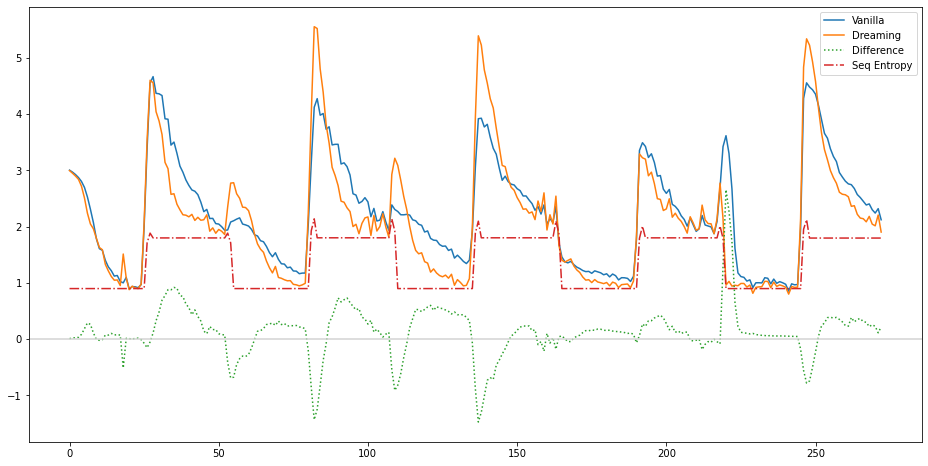

In [179]:
xx = range(losses_vanilla.shape[1])
mean_vanilla = losses_vanilla.mean(axis=0)
std_vanilla = losses_vanilla.std(axis=0)
mean_dreaming = losses_dreaming.mean(axis=0)
std_dreaming = losses_dreaming.std(axis=0)

entropy_seq = results[0]['ns_seq_dict']['entropy_seq']

plt.figure(figsize=(16,8))
plt.fill_between(xx, mean_vanilla-std_vanilla, mean_vanilla+std_vanilla, alpha=0.4)
plt.plot(xx, mean_vanilla, label='Vanilla')
plt.fill_between(xx, mean_dreaming-std_dreaming, mean_dreaming+std_dreaming, alpha=0.4)
plt.plot(xx, mean_dreaming, label='Dreaming')
plt.plot(xx, mean_vanilla - mean_dreaming, ':', label='Difference')

plt.plot(entropy_seq[::seq_length], '-.', label='Seq Entropy')
plt.axhline(0, color='lightgrey')
plt.legend(loc='best')
plt.show()

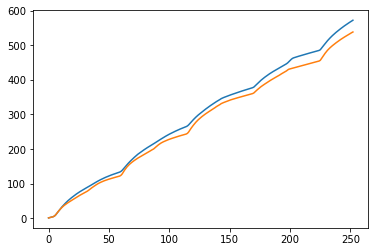

In [180]:
plt.plot(mean_vanilla[20:].cumsum())
plt.plot(mean_dreaming[20:].cumsum())

In [181]:
seq = results[0]['ns_seq_dict']['seq']

past = seq_length*2

distrs_seq_approx = []
entropy_seq_approx = []

for k in range(1, len(seq)):
    fr = k - past
    if fr < 0: fr = 0
    to = k
    distr = np.array([0] * n_bins)
    for s in seq[fr:to]:
        distr[s] += 1
    distr = distr / distr.sum()
    distrs_seq_approx.append(distr)
    entropy_seq_approx.append(entropy(distr))

In [182]:
len(results)

1

In [183]:
k = 0
type(results[k]['distributions_vanilla'])

list

In [184]:
entropy_vanilla = []
entropy_dreaming = []
#k = 0
for k in range(len(results)):
    print(k)
    entropy_vanilla.append([])
    entropy_dreaming.append([])
    distributions_vanilla = results[k]['distributions_vanilla']
    distributions_dreaming = results[k]['distributions_dreaming']
    for distr in distributions_vanilla:
        entropy_vanilla[k].append(entropy(distr, norm=True))
    
    for distr in distributions_dreaming:
        entropy_dreaming[k].append(entropy(distr, norm=True))
        
entropy_vanilla = np.array(entropy_vanilla)
entropy_dreaming = np.array(entropy_dreaming)

0


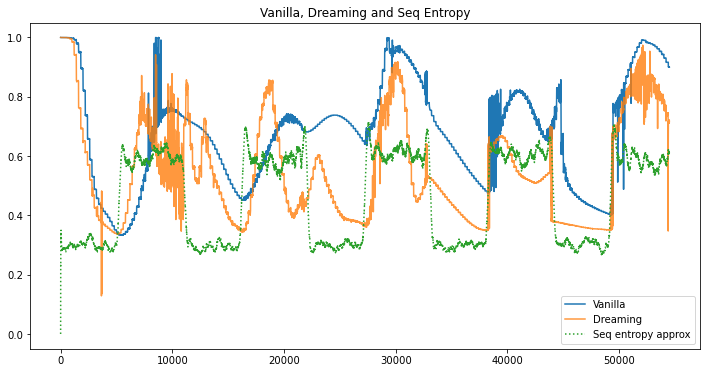

In [185]:
plt.figure(figsize=(12,6))

evmean = entropy_vanilla.mean(axis=0)
evstd = entropy_vanilla.std(axis=0)
edmean = entropy_dreaming.mean(axis=0)
edstd = entropy_dreaming.std(axis=0)

xx = range(len(evmean))

plt.fill_between(xx, evmean+evstd, evmean-evstd)
plt.plot(xx, evmean, label='Vanilla')
plt.fill_between(xx, edmean+edstd, edmean-edstd)
plt.plot(xx, edmean, label='Dreaming', alpha=0.8)
plt.plot(entropy_seq_approx/np.log(n_bins), ':', label='Seq entropy approx')
plt.legend(loc='best')
plt.title('Vanilla, Dreaming and Seq Entropy')
plt.show()

In [186]:
entropy_vanilla.shape, entropy_dreaming

((1, 54499),
 array([[0.99935011, 0.99930769, 0.99928652, ..., 0.7162232 , 0.71644843,
         0.71673183]]))

Correlation vanilla 0.517218737194726
Correlation dreaming 0.5340060105268449


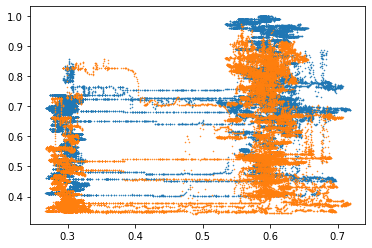

In [187]:
fr = 10000
plt.scatter((entropy_seq_approx/np.log(n_bins))[fr:], evmean[fr:], marker='.', s=1)
plt.scatter((entropy_seq_approx/np.log(n_bins))[fr:], edmean[fr:], marker='.', s=1)
print('Correlation vanilla', np.corrcoef((entropy_seq_approx/np.log(n_bins))[fr:], evmean[fr:])[0,1])
print('Correlation dreaming', np.corrcoef((entropy_seq_approx/np.log(n_bins))[fr:], edmean[fr:])[0,1])

In [188]:
entropy_vanilla[2].shape

IndexError: index 2 is out of bounds for axis 0 with size 1

/tmp/ipykernel_159543/47186581.py:37: RuntimeWarning: invalid value encountered in sqrt
  std.append(np.sqrt(sumt / len_tlist))


Vanilla: -1330.0 0.0
Dreaming: -690.0 0.0


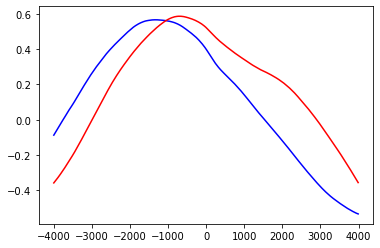

In [189]:
wlen = 10
fr = 5000

ccv = []
ccd = []

yy0, _ = ma(entropy_seq_approx[fr:]/np.log(n_bins), wlen)

for k in range(len(results)):
    crosscorr_vanilla = []
    crosscorr_dreaming = []
    
    yy1, _ = ma(entropy_vanilla[k][fr:], wlen)
    yy2, _ = ma(entropy_dreaming[k][fr:], wlen)
    
    fro = -4000
    too = 4000
    step = 10
    for k in np.arange(fro, too, step):
        if k < 0:
            fr0 = 0
            to0 = len(yy0) + k
            fr1 = -k
            to1 = len(yy1)
        else:
            fr0 = k
            to0 = len(yy0)
            fr1 = 0
            to1 = len(yy1) - k

        crosscorr_vanilla.append(np.corrcoef(yy0[fr0:to0], yy1[fr1:to1])[0,1])
        crosscorr_dreaming.append(np.corrcoef(yy0[fr0:to0], yy2[fr1:to1])[0,1])

    plt.plot(np.arange(fro, too, step), crosscorr_vanilla, 'b')
    plt.plot(np.arange(fro, too, step), crosscorr_dreaming, 'r')

    ccv.append(np.argmax(crosscorr_vanilla)*step + fro)
    ccd.append(np.argmax(crosscorr_dreaming)*step + fro)
    
ccv = np.array(ccv)
ccd = np.array(ccd)

print('Vanilla:', ccv.mean(), ccv.std())
print('Dreaming:', ccd.mean(), ccd.std())

In [190]:
#import scipy.stats
#scipy.stats.pearsonr(yy0, yy1), scipy.stats.pearsonr(yy0, yy2)

In [191]:
distrs_seq = results[0]['ns_seq_dict']['distrs_seq']

In [192]:
KL_vanilla = []
for k, distr in enumerate(distributions_vanilla):
    #print(distr.shape, np.array(ns_seq_dict['distrs'][k]).shape)
    KL_vanilla.append(KL_divergence(distrs_seq[k+1], distr))
KL_dreaming = []
for k, distr in enumerate(distributions_dreaming):
    KL_dreaming.append(KL_divergence(distrs_seq[k+1], distr))

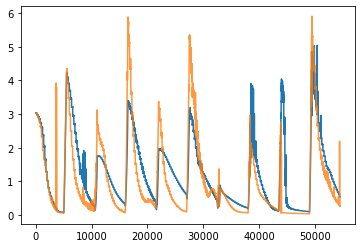

In [193]:
plt.plot(KL_vanilla)
plt.plot(KL_dreaming, alpha=0.8)

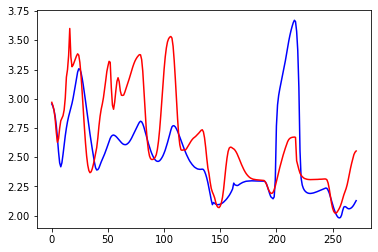

In [194]:
for k in range(len(results)):
    plt.plot(results[k]['loss_past_information_vanilla'], 'b')
    plt.plot(results[k]['loss_past_information_dreaming'], 'r')

In [195]:
lpiv.shape, lpiv.mean(axis=0).shape

((1, 154), (154,))

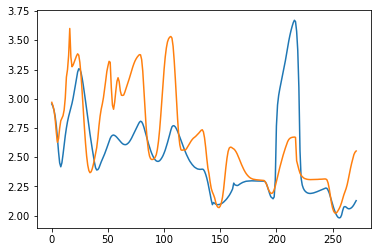

In [196]:
lpiv = []
lpid = []
for k in range(len(results)):
    lpiv.append(results[k]['loss_past_information_vanilla'])
    lpid.append(results[k]['loss_past_information_dreaming'])
lpiv = np.array(lpiv)
lpid = np.array(lpid)

xx = range(lpid.shape[1])
plt.fill_between(xx, lpiv.mean(axis=0)-lpiv.std(axis=0), lpiv.mean(axis=0)+lpiv.std(axis=0), alpha=0.4)
plt.plot(xx, lpiv.mean(axis=0))
plt.fill_between(xx, lpid.mean(axis=0)-lpid.std(axis=0), lpid.mean(axis=0)+lpid.std(axis=0), alpha=0.4)
plt.plot(xx, lpid.mean(axis=0))

In [197]:
a += 1

NameError: name 'a' is not defined